###Prepare

In [1]:
!ls

drive  sample_data


In [2]:
cd drive/MyDrive/DeepLearningCourse

/content/drive/MyDrive/DeepLearningCourse


In [3]:
# !unzip -o images.zip #-o  overwrite files WITHOUT prompting(覆蓋文件不提示)

In [4]:
import numpy as np
import cv2 
from google.colab.patches import cv2_imshow
import random
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import sklearn
from sklearn.model_selection import learning_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC # support vector classifier
import os
%matplotlib inline

### Read images & create histogram

1. convert to gray
2. BoVW : convert to histogram by BoVW

In [5]:
# create BoVW:return Kmeans
def BoVW():

    SIFT_features=[]

    # Specify the folder path
    folder_path = "images"

    # Loop over the subfolders in the folder
    for subdir in os.listdir(folder_path):
        subdir_path = os.path.join(folder_path, subdir)
        if os.path.isdir(subdir_path):
            # Loop over the files in the subfolder
            count = 0
            for filename in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, filename)

                if os.path.isfile(file_path):
                    img = cv2.imread(file_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    kp, des = sift.detectAndCompute(img,None) 
                    # print(des)

                    # Sample keypoints randomly
                    sample_num = 50
                    if len(des) > sample_num:
                        des = random.sample(des.tolist(), sample_num)

                    SIFT_features.extend(des)
                    count += 1
                
                
                # choose 10 images per class
                if count >= 2:
                    break

    kmeans = KMeans(n_clusters = n_clusters_, random_state=0, n_init=10).fit(SIFT_features)
    # n_init = "auto" 在某些版本才有, import 時需確認!

    return kmeans
        

In [6]:
# help function of feature extraction function
# create histogram:return histogram of an image
def create_histogram(des):
    hist = [0]*n_clusters_
    for i in range(len(des)):
        X=[]
        X.append(des[i])
        idx = vocab.predict(X)

        idx = idx[0]
        # print(idx)
        hist[idx]+=1
    
    return hist


In [7]:
# init of main func

n_clusters_ = 30
sift = cv2.xfeatures2d.SIFT_create()
vocab = BoVW()

In [8]:
# main func : read image & feature extract

def LoadImg2Hist(string):
    count_img = [0]*50
    count_lim = 500

    path = ''
    if string == 'train':
        path = 'train.txt'
    elif string == 'test':
        path = 'test.txt'
    elif string == 'val':
        path = 'val.txt'

    with open(path,'r') as fp:
        count=0
        X=[]
        Y=[]
        # num_read_lines = 20 # num of read lines in txt file (train.txt ...)
        # while count!=num_read_lines:
        # c = 0
        while True:
            # Get next line from file
            line = fp.readline()

            # if line is empty
            # end of file is reached
            if not line:
                break
              
            # c+=1
            # if c < 32000:
            #     continue
            # if c == 32500:
            #     break
            
            loc ,ans = line.split(' ')
            ans = int(ans[:-1]) #'\n' is "a" character

            if count_img[ans]>=count_lim:
                continue
            
            if os.path.isfile(loc)==True:

                img = cv2.imread(loc)
                if img is None:
                    continue

                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                kp, des = sift.detectAndCompute(img,None) 
                if des is None:
                    continue

                hist = create_histogram(des) # convert img to histogram(feature array)

                X.append(hist)
                Y.append(ans)

                count_img[ans]+=1
                count+=1

                if count%1000==0:
                    print(count)
                
        print(count)

    return X,Y
        


In [9]:
from sklearn.preprocessing import StandardScaler

def standardscaler(X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X


In [10]:

trainX, trainY = LoadImg2Hist('train')
valX, valY = LoadImg2Hist('val')
testX, testY = LoadImg2Hist('test')

trainX = standardscaler(trainX)
valX = standardscaler(valX)
testX = standardscaler(testX)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
25000
450
450


#### shuffle training set:  
By shuffling, you allow your model to "see" a wide range of data points each belonging to different classes in the context of classification.   
If the model goes through a sorted training data, your model runs the risk of overfitting to certain classes.

In [11]:
'''
shuffle:
If the model goes through a sorted training data, 
your model runs the risk of overfitting to certain classes.
'''
#shuffle training dataset!
trainX, trainY = sklearn.utils.shuffle(trainX, trainY, random_state=42)


### evaluation function : top1, top5

In [12]:
# top1
def top1_accuracy(y_pred, y_true):
    count = 0
    num = len(y_pred)
    for i in range(num):
        if y_pred[i] == y_true[i]:
            count+=1
    return count/num


In [13]:
# as long as it's in top 5, count as predicted correct
def top5_accuracy(y_pred, y_true):
    count = 0
    num = len(y_pred)
    for i in range(num):
        for j in range(5):
            if j < len(y_pred[i]) and y_pred[i][j]== y_true[i]:
                count+=1
                break
    return count/num

### Model 1 : SGDClassifier

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


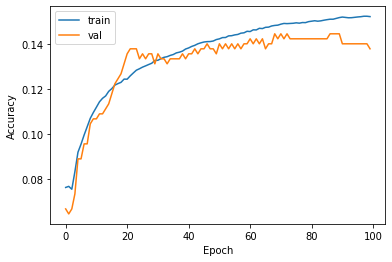

In [15]:


# Define the SGD model
SGD_model = SGDClassifier(loss="log", penalty="l2", random_state=42, max_iter=1, tol=None)

# Train the model iteratively, and compute the multi_logloss after each iteration
n_epochs = 100
train_accuracies = []
val_accuracies = []
for epoch in range(n_epochs):
    SGD_model.partial_fit(trainX, trainY, classes = np.unique(trainY))# incremental training
    train_accuracies.append(top1_accuracy(trainY, SGD_model.predict(trainX)))
    val_accuracies.append(top1_accuracy(valY, SGD_model.predict(valX)))

# Plot the multi_logloss during training
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [16]:
# calculate predicted val/test accuracy
def predict_accuracy(model, X,Y):

    #top1
    y_pred = model.predict(X) # type = ndarray
    top1 = top1_accuracy(y_pred, Y)

    #top5
    y_pred = model.predict_proba(X)
    best_5 = np.argsort(y_pred, axis=1)[:,-5:] # 取後面5個
    top5 = top5_accuracy(best_5, Y)

    return top1, top5

In [17]:

val_top1_accu, val_top5_accu = predict_accuracy(SGD_model, valX, valY)
test_top1_accu, test_top5_accu = predict_accuracy(SGD_model, testX, testY)
print(f'validation top-1 accuracy : {val_top1_accu:0.2f}')
print(f'validation top-5 accuracy : {val_top5_accu:0.2f}')
print(f'testing top-1 accuracy : {test_top1_accu:0.2f}')
print(f'testing top-5 accuracy : {test_top5_accu:0.2f}')

validation top-1 accuracy : 0.14
validation top-5 accuracy : 0.39
testing top-1 accuracy : 0.15
testing top-5 accuracy : 0.40


###Model 2 : CatBoost
CatBoost is an algorithm for gradient boosting on decision trees.

In [18]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.3 MB/s eta 0:00:00


In [19]:
from catboost import CatBoostClassifier

Learning rate set to 0.277515
0:	learn: 3.7857796	test: 3.8087381	best: 3.8087381 (0)	total: 910ms	remaining: 1m 30s
1:	learn: 3.6973028	test: 3.7276145	best: 3.7276145 (1)	total: 1.82s	remaining: 1m 29s
2:	learn: 3.6360792	test: 3.6799171	best: 3.6799171 (2)	total: 2.91s	remaining: 1m 33s
3:	learn: 3.5972545	test: 3.6509497	best: 3.6509497 (3)	total: 4.12s	remaining: 1m 38s
4:	learn: 3.5580123	test: 3.6219372	best: 3.6219372 (4)	total: 5.35s	remaining: 1m 41s
5:	learn: 3.5200975	test: 3.5949655	best: 3.5949655 (5)	total: 6.73s	remaining: 1m 45s
6:	learn: 3.4848491	test: 3.5737451	best: 3.5737451 (6)	total: 7.85s	remaining: 1m 44s
7:	learn: 3.4558803	test: 3.5520989	best: 3.5520989 (7)	total: 9.67s	remaining: 1m 51s
8:	learn: 3.4356015	test: 3.5450032	best: 3.5450032 (8)	total: 12.1s	remaining: 2m 2s
9:	learn: 3.4260850	test: 3.5407617	best: 3.5407617 (9)	total: 14.2s	remaining: 2m 7s
10:	learn: 3.4101722	test: 3.5267131	best: 3.5267131 (10)	total: 15.8s	remaining: 2m 7s
11:	learn: 3.3

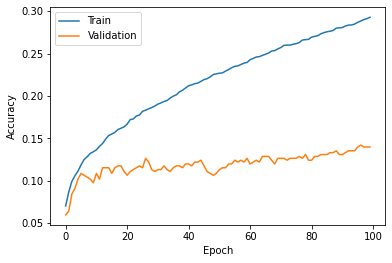

In [20]:
# Initialize the model
n_epochs = 100
cat_model = CatBoostClassifier(loss_function='MultiClass', custom_metric="Accuracy", iterations = n_epochs)

# Train the model
cat_model.fit(trainX, trainY, eval_set=(valX, valY))

# Generate training accuracy graph
train_acc = cat_model.get_evals_result()['learn']['Accuracy']
val_acc = cat_model.get_evals_result()['validation']['Accuracy']
iterations = range(len(train_acc))
plt.plot(iterations, train_acc, label='Train')
plt.plot(iterations, val_acc, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# model.get_evals_result() : dict_keys(['learn', 'validation'])



In [21]:
# calculate predicted val/test accuracy
# problem! predict_prob -> _predict_proba_lr
val_top1_accu, val_top5_accu = predict_accuracy(cat_model, valX, valY)
test_top1_accu, test_top5_accu = predict_accuracy(cat_model, testX, testY)
print(f'validation top-1 accuracy : {val_top1_accu:0.2f}')
print(f'validation top-5 accuracy : {val_top5_accu:0.2f}')
print(f'testing top-1 accuracy : {test_top1_accu:0.2f}')
print(f'testing top-5 accuracy : {test_top5_accu:0.2f}')

validation top-1 accuracy : 0.14
validation top-5 accuracy : 0.42
testing top-1 accuracy : 0.16
testing top-5 accuracy : 0.43


### Model 3 : MLP


In [22]:
from sklearn.neural_network import MLPClassifier

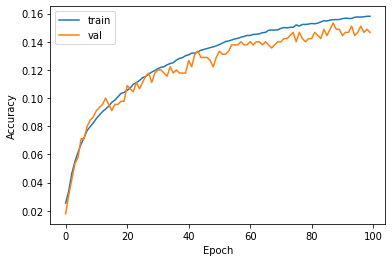

In [23]:


# Define the Perceptron model
mlp_model = MLPClassifier(solver='sgd')

# Train the model iteratively, and compute the multi_logloss after each iteration
n_epochs = 100
train_accuracies = []
val_accuracies = []
for epoch in range(n_epochs):
    mlp_model.partial_fit(trainX, trainY, classes = np.unique(trainY))
    train_accuracies.append(top1_accuracy(trainY, mlp_model.predict(trainX)))
    val_accuracies.append(top1_accuracy(valY, mlp_model.predict(valX)))

# Plot the multi_logloss during training
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [24]:
val_top1_accu, val_top5_accu = predict_accuracy(mlp_model, valX, valY)
test_top1_accu, test_top5_accu = predict_accuracy(mlp_model, testX, testY)
print(f'validation top-1 accuracy : {val_top1_accu:0.2f}')
print(f'validation top-5 accuracy : {val_top5_accu:0.2f}')
print(f'testing top-1 accuracy : {test_top1_accu:0.2f}')
print(f'testing top-5 accuracy : {test_top5_accu:0.2f}')

validation top-1 accuracy : 0.15
validation top-5 accuracy : 0.41
testing top-1 accuracy : 0.15
testing top-5 accuracy : 0.41
